In [2]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, precision_recall_fscore_support
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AlbertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
train_data = pd.read_csv('issues_train.csv')
test_data = pd.read_csv('issues_test.csv')

print(train_data.head(), test_data.head())

             repo           created_at label  \
0  facebook/react  2023-08-26 06:33:37   bug   
1  facebook/react  2023-07-28 05:16:12   bug   
2  facebook/react  2023-07-13 21:58:31   bug   
3  facebook/react  2023-06-14 02:31:20   bug   
4  facebook/react  2023-06-03 11:29:44   bug   

                                               title  \
0  [DevTools Bug] Cannot add node "1" because a n...   
1  [DevTools Bug]: Devtools extension build faili...   
2  [DevTools Bug]: Deprecated __REACT_DEVTOOLS_GL...   
3  [DevTools Bug] Cannot remove node "0" because ...   
4  [DevTools Bug] Cannot remove node "103" becaus...   

                                                body  
0  ### Website or app\n\nPrivate repo cannot give...  
1  ### Website or app\n\nN/A\n\n### Repro steps\n...  
2  ### Website or app\n\nhttps://github.com/open-...  
3  ### Website or app\n\nlocal\n\n### Repro steps...  
4  ### Website or app\n\nlocalhost\n\n### Repro s...                repo           created_at label

In [5]:
# perform pre-processing steps
def preprocess(text):
    if isinstance(text, float):
        return ''   
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token) != '']
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

train_data['title_processed'] = train_data['title'].apply(preprocess)
train_data['body_processed'] = train_data['body'].apply(preprocess)

test_data['title_processed'] = test_data['title'].apply(preprocess)
test_data['body_processed'] = test_data['body'].apply(preprocess)

print("Train Data:")
print(train_data[['title_processed', 'body_processed']].head())

print("\nTest Data:")
print(test_data[['title_processed', 'body_processed']].head())

Train Data:
                                     title_processed  \
0      devtools bug add node 1 node id already store   
1  devtools bug devtools extension build failing ...   
2    devtools bug deprecated reactdevtoolsglobalhook   
3  devtools bug remove node 0 matching node found...   
4  devtools bug remove node 103 matching node fou...   

                                      body_processed  
0  website app private repo give access applicati...  
1  website app na repro step working react devtoo...  
2  website app http githubcomopensourcelabsreacti...  
3  website app local repro step open reactdevtool...  
4  website app localhost repro step often bug hap...  

Test Data:
                                     title_processed  \
0  bug 1830canary rendertostring hoist tag top wo...   
1  devtools bug chrome extension get disconnected...   
2    devtools bug deprecated reactdevtoolsglobalhook   
3  devtools bug react devtools stuck loading reac...   
4  bug radio button onchange 

In [5]:
train_data.isnull().sum()

repo               0
created_at         0
label              0
title              0
body               0
title_processed    0
body_processed     0
dtype: int64

In [6]:
# Selecting features and labels
X_train = train_data['title_processed'] + ' ' + train_data['body_processed']
y_train = train_data['label']
X_test = test_data['title_processed'] + ' ' + test_data['body_processed']
y_test = test_data['label']

In [7]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)


In [8]:
# Convert labels to integers
label_map = {label: i for i, label in enumerate(y_train.unique())}
train_labels = [label_map[label] for label in y_train]
test_labels = [label_map[label] for label in y_test]

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

In [9]:
# Define model
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(label_map)).to('cuda')

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define training parameters
batch_size = 16
num_epochs = 25
learning_rate = 2e-5

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [11]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Training loop
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

training_time = time.time() - start_time

Epoch 1/25, Loss: 96.66728603839874
Epoch 2/25, Loss: 81.12650156021118
Epoch 3/25, Loss: 70.40381219983101
Epoch 4/25, Loss: 55.55950900912285
Epoch 5/25, Loss: 45.80357030034065
Epoch 6/25, Loss: 36.06425926089287
Epoch 7/25, Loss: 26.435061272233725
Epoch 8/25, Loss: 23.092486936599016
Epoch 9/25, Loss: 15.698918249458075
Epoch 10/25, Loss: 14.997640463523567
Epoch 11/25, Loss: 10.923192436806858
Epoch 12/25, Loss: 8.322051440365613
Epoch 13/25, Loss: 5.266238453332335
Epoch 14/25, Loss: 7.519276721868664
Epoch 15/25, Loss: 5.098989132558927
Epoch 16/25, Loss: 4.342844140483066
Epoch 17/25, Loss: 1.8169786084908992
Epoch 18/25, Loss: 2.070665230276063
Epoch 19/25, Loss: 1.8008226619567722
Epoch 20/25, Loss: 12.980318125337362
Epoch 21/25, Loss: 15.767098092474043
Epoch 22/25, Loss: 6.61527309473604
Epoch 23/25, Loss: 2.328387858811766
Epoch 24/25, Loss: 4.386208918178454
Epoch 25/25, Loss: 3.986780139617622


In [13]:
import numpy as np

def calculate_metrics(labels, preds):
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, preds, average=None, labels=np.unique(preds))
    avg_precision, avg_recall, avg_f1_score, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return precision, recall, f1_score, avg_precision, avg_recall, avg_f1_score

# Evaluation
model.eval()
all_preds = []
all_labels = []
eval_start_time = time.time()
for batch in test_dataloader:
    batch = tuple(t.to('cuda') for t in batch)  # Move batch to the appropriate device
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    preds = np.argmax(logits.cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_labels.extend(batch[2].cpu().numpy())
    
evaluation_time = time.time() - eval_start_time

# Classification report
target_names = list(label_map.keys())
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

         bug       0.74      0.79      0.77       500
     feature       0.81      0.76      0.78       500
    question       0.68      0.68      0.68       500

    accuracy                           0.74      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.75      0.74      0.74      1500



In [26]:
print(test_data.columns)

Index(['repo', 'created_at', 'label', 'title', 'body', 'title_processed',
       'body_processed', 'predictions'],
      dtype='object')


In [17]:
# Classification cross repo report
repo_metrics = {}
for repo, data in grouped_data:
    repo_labels = data['label'].map(label_map)  
    repo_preds = data['predictions']
    precision, recall, f1_score, support = precision_recall_fscore_support(repo_labels, repo_preds, average=None, labels=np.unique(repo_preds))
    
    if len(precision) < 3:
        precision = np.append(precision, 0)  
        recall = np.append(recall, 0)  
        f1_score = np.append(f1_score, 0)  
    
    avg_precision, avg_recall, avg_f1_score, _ = precision_recall_fscore_support(repo_labels, repo_preds, average='weighted')
    repo_metrics[repo] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1_score': avg_f1_score
    }

for repo, metrics in repo_metrics.items():
    print(f"\nMetrics for Repository: {repo}")
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1-score:", metrics['f1_score'])
    print("Average Precision:", metrics['avg_precision'])
    print("Average Recall:", metrics['avg_recall'])
    print("Average F1-score:", metrics['avg_f1_score'])




Metrics for Repository: bitcoin/bitcoin
Precision: [0.64705882 0.75789474 0.52427184]
Recall: [0.66 0.72 0.54]
F1-score: [0.65346535 0.73846154 0.5320197 ]
Average Precision: 0.6430751350105705
Average Recall: 0.64
Average F1-score: 0.6413155298098965

Metrics for Repository: facebook/react
Precision: [0.88073394 0.7816092  0.72115385]
Recall: [0.96 0.68 0.75]
F1-score: [0.91866029 0.72727273 0.73529412]
Average Precision: 0.7944989955034245
Average Recall: 0.7966666666666666
Average F1-score: 0.7937423773337087

Metrics for Repository: microsoft/vscode
Precision: [0.74725275 0.72727273 0.64545455]
Recall: [0.68 0.72 0.71]
F1-score: [0.71204188 0.72361809 0.67619048]
Average Precision: 0.7066600066600066
Average Recall: 0.7033333333333334
Average F1-score: 0.7039501504864971

Metrics for Repository: opencv/opencv
Precision: [0.62184874 0.84693878 0.75903614]
Recall: [0.74 0.83 0.63]
F1-score: [0.67579909 0.83838384 0.68852459]
Average Precision: 0.7426078865281053
Average Recall: 0.73

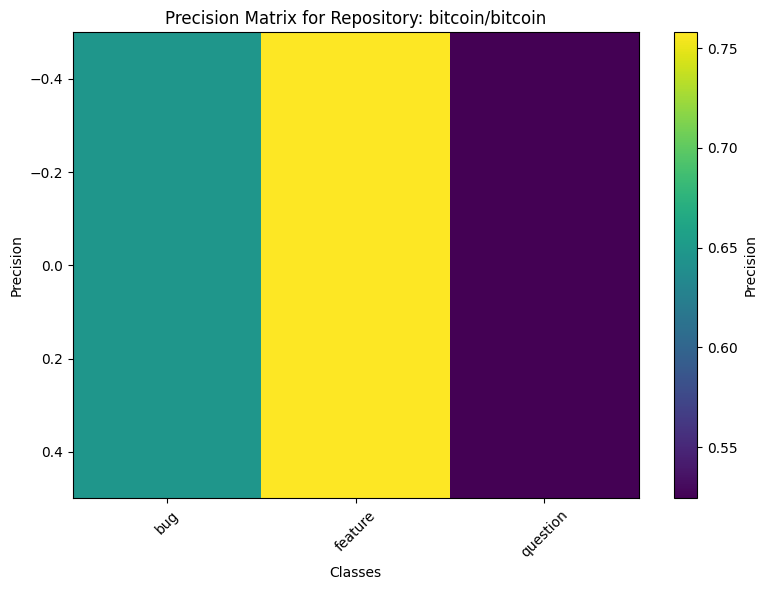

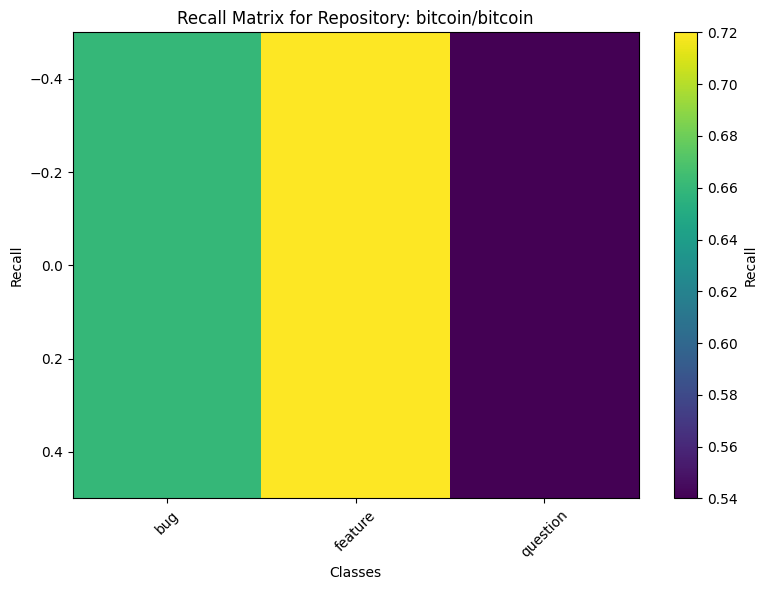

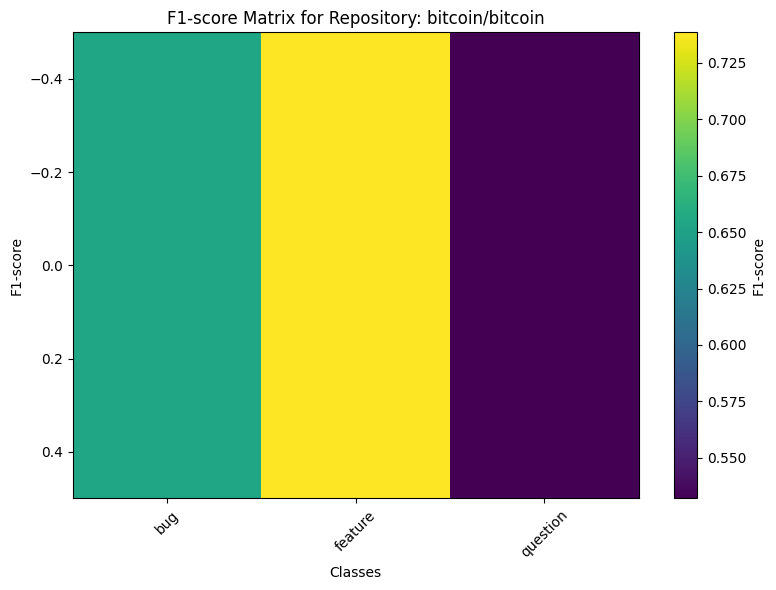

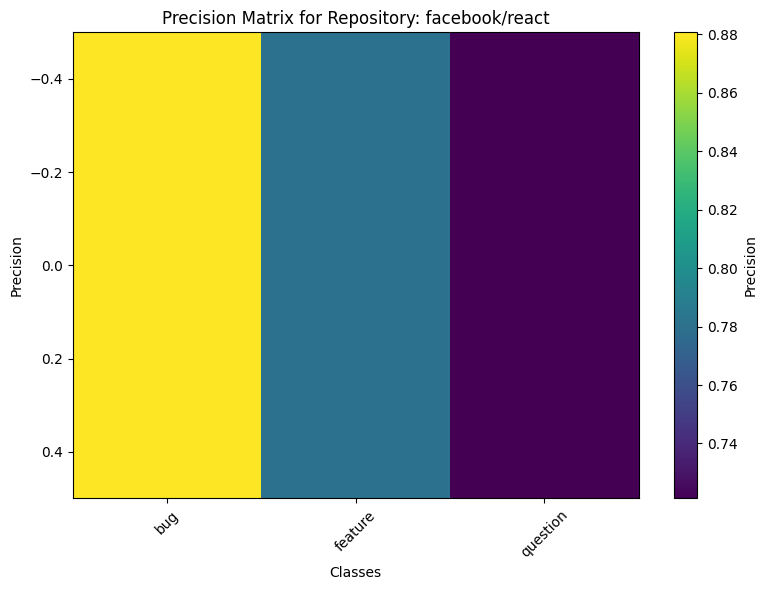

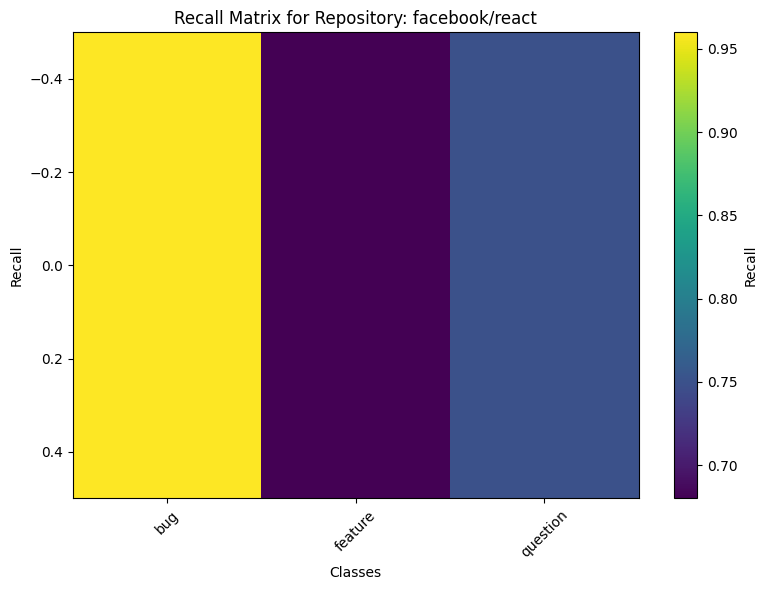

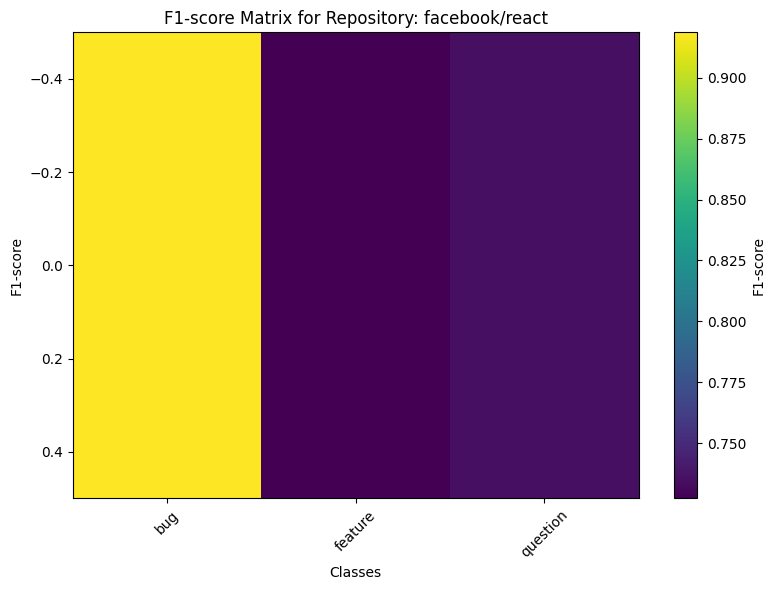

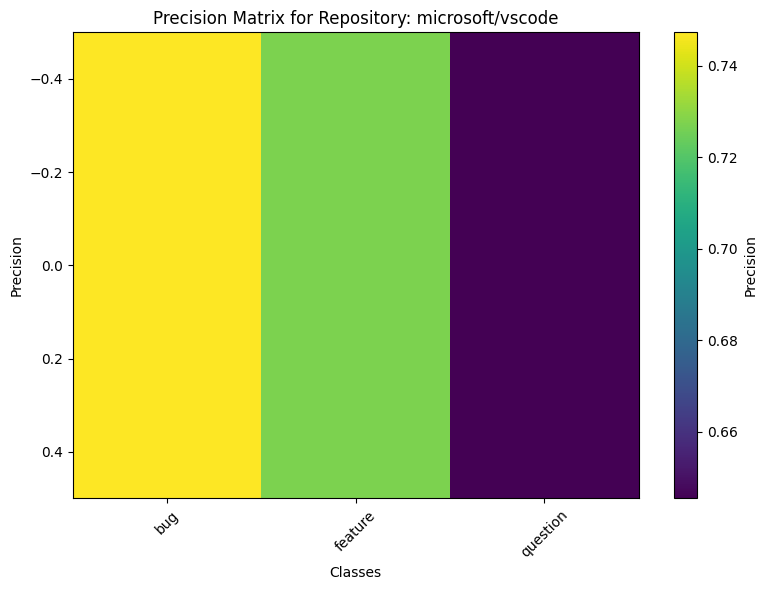

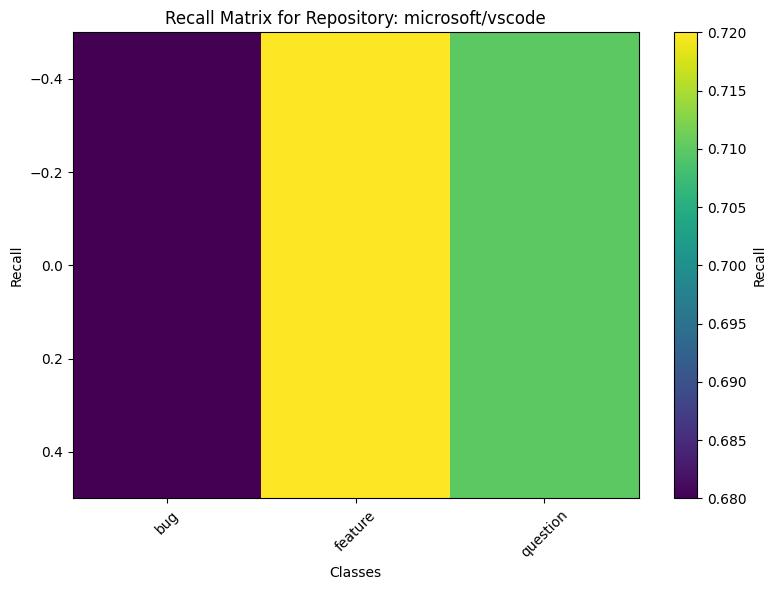

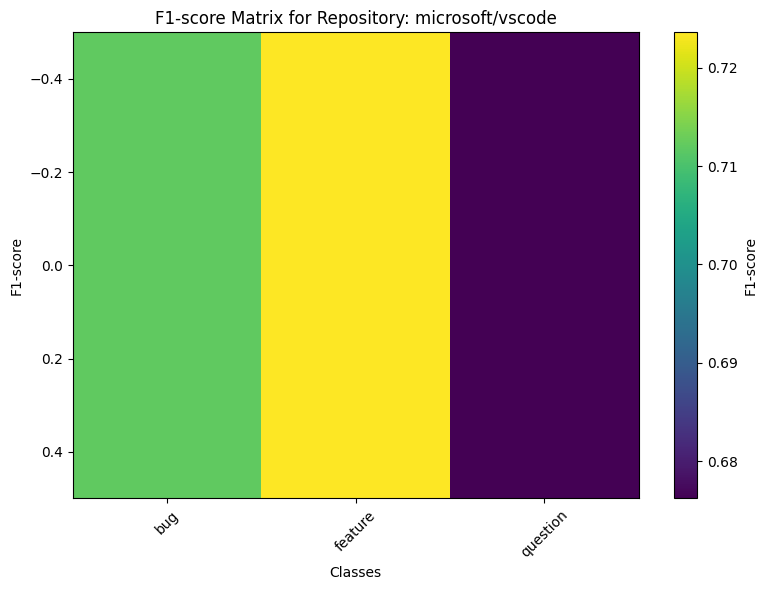

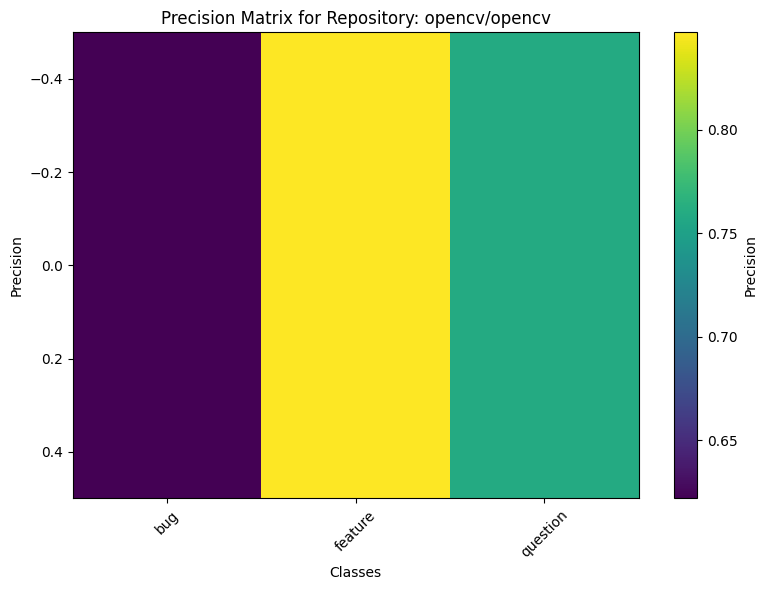

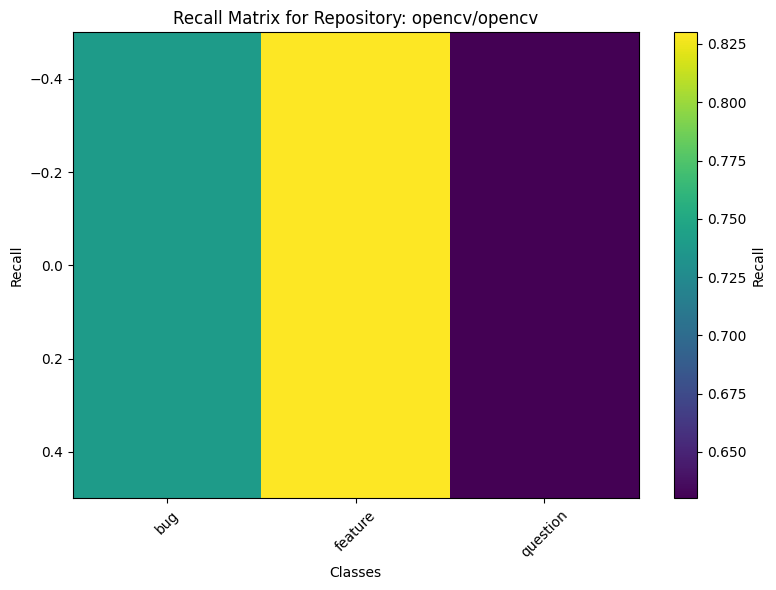

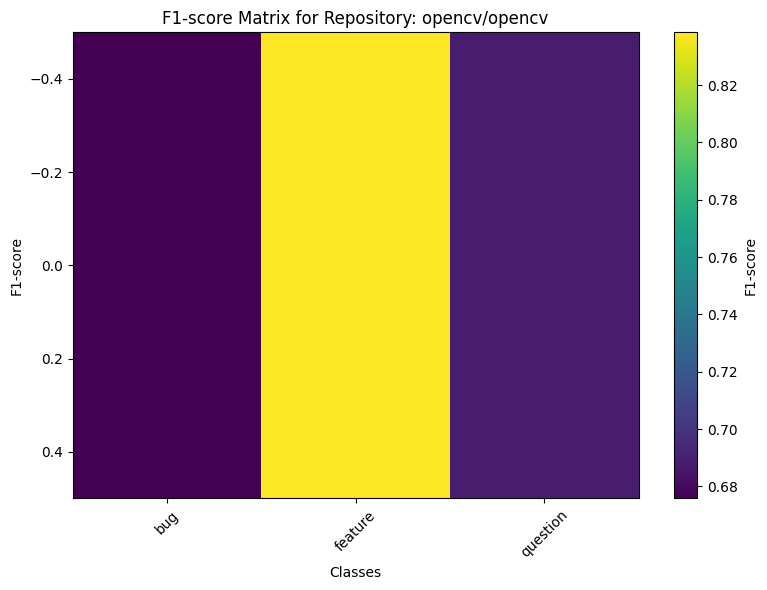

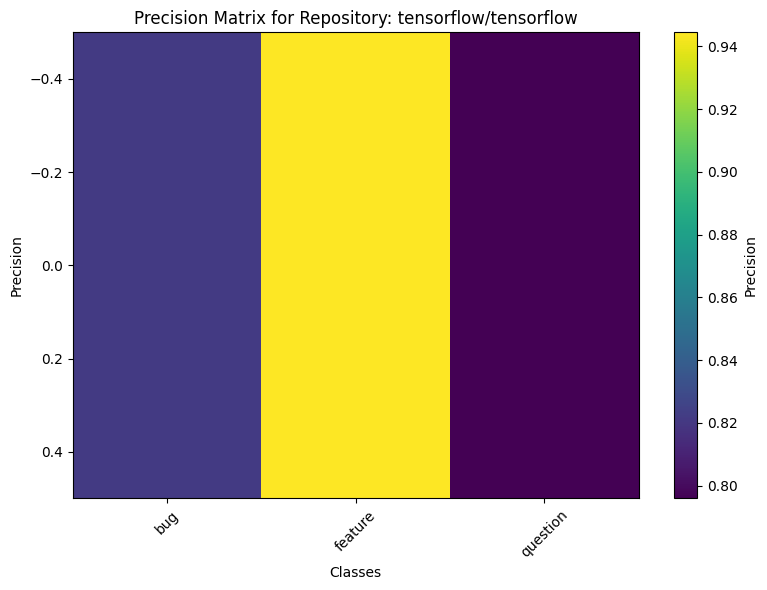

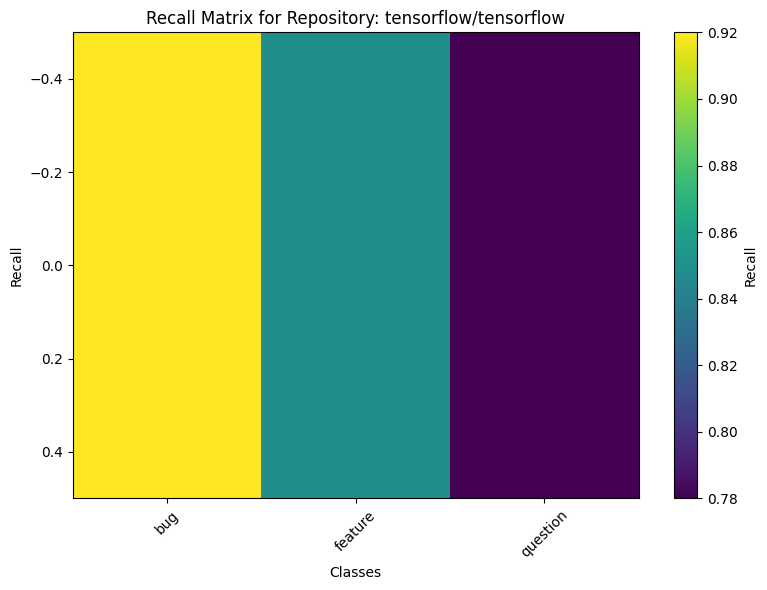

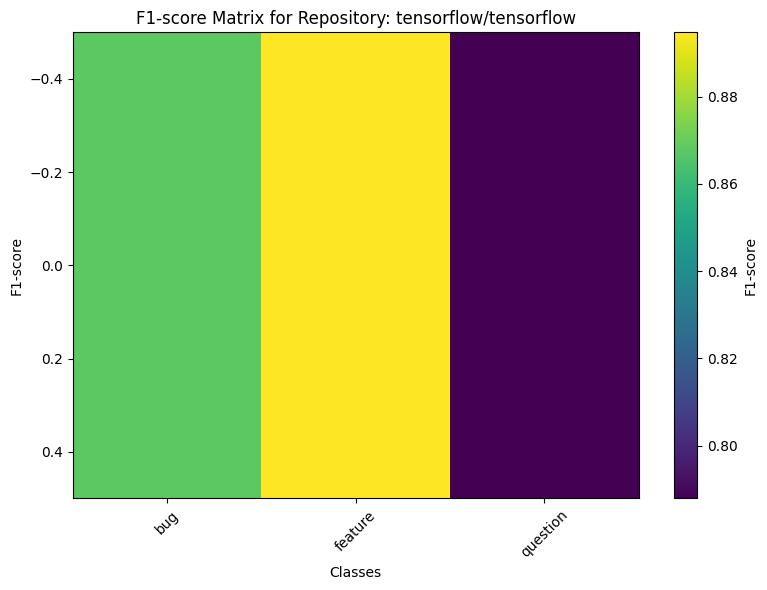

In [20]:
import matplotlib.pyplot as plt

# visualizing precision, recall, f1-scores
for repo, metrics in repo_metrics.items():
    classes = list(label_map.keys())
    
    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['precision']], cmap='viridis', aspect='auto')
    plt.title(f'Precision Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('Precision')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='Precision')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['recall']], cmap='viridis', aspect='auto')
    plt.title(f'Recall Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='Recall')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['f1_score']], cmap='viridis', aspect='auto')
    plt.title(f'F1-score Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('F1-score')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='F1-score')
    plt.tight_layout()
    plt.show()


In [25]:
model.save_pretrained('albert')

Inference

In [1]:
import torch
from transformers import AlbertForSequenceClassification, AutoTokenizer
import time

model_path = '/home/codegen_inference/albert'
model = AlbertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [5]:
input_text = "renderToString hoists some tags to top. please provide clear concise description bug include screenshots needed please test using latest version relevant react package make sure issue already fixed react version 1830canary493f72b0a20230727 step reproduce 1 run following code j import reactdomserver reactdomserver const element html head meta title hoisted meta charset utf8 title title title script tag hoisted script src foo script hoisted script src foo async script head html consolelog reactdomserverrendertostring element bug get fixed much faster run code doesnt dependency react issue without reproduction step code example may immediately closed actionable link code example http codesandboxiosreact1830canary493f72b0a20230727ssrhoistbuglvhj45 filesrcindexjs please provide codesandbox http codesandboxiosnew link repository github provide minimal code example reproduces problem may provide screenshot application think relevant bug report tip providing minimal example http stackoverflowcomhelpmcve current behavior consolelog output meta charset utf8 script src foo async script title title title html head script src foo script head html expected behavior consolelog output html head meta charset utf8 title title title script src foo script script src foo async script head html."

inputs = tokenizer(input_text, return_tensors="pt")

start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
inference_time = time.time() - start_time

label_map = {0: 'bug', 1: 'feature', 2: 'question'}

predicted_label_idx = torch.argmax(outputs.logits)
predicted_label = label_map[predicted_label_idx.item()]

print("Predicted Label:", predicted_label)
print("Inference Time:", inference_time, "seconds")


Predicted Label: bug
Inference Time: 0.44290995597839355 seconds
